In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from datetime import datetime

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)

!pip install pydot
!rm -rf ./logs/ 

# TensorFlow Dataset

TensorFlow's [dataset](https://www.tensorflow.org/guide/data) object `tf.data.Dataset` allows us to write descriptive and efficient dataset input pipelines. It allows the following pattern:

1. Create a source dataset from the input data
2. Apply transformations to preprocess the data
3. Iterate over the dataset and process all the elements

The iteration happens via a streamlining method, which works well with datasets that are large and that don't have to completely fit into the memory.

We can consume any python iterable nested data structure by the `tf.data.Dataset` object, however we often use the following format that **Keras** expects, such as the following `(feature, label)` or `(X, y)` pairs is all that's needed for `tf.keras.Model.fit` and `tf.keras.Model.evaluate`.

Here is an example loading the digits dataset into a `tf.data.Dataset` object, using the `tf.data.Dataset.from_tensors()`

In [2]:
# Load the digits dataset that we have been using
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow import keras

digits = datasets.load_digits()

(X, y) = datasets.load_digits(return_X_y=True)
X = X.astype(np.float32)
y = y.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

digits_train_ds = tf.data.Dataset.from_tensors((X_train, y_train))
print(list(digits_train_ds))        
print('\n', digits_train_ds)

[(<tf.Tensor: shape=(1437, 64), dtype=float32, numpy=
array([[ 0.,  0.,  3., ..., 13.,  4.,  0.],
       [ 0.,  0.,  9., ...,  3.,  0.,  0.],
       [ 0.,  0.,  0., ...,  6.,  0.,  0.],
       ...,
       [ 0.,  0.,  9., ..., 16.,  2.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  1.,  0.,  0.]], dtype=float32)>, <tf.Tensor: shape=(1437,), dtype=int32, numpy=array([6, 0, 0, ..., 2, 7, 1], dtype=int32)>)]

 <TensorDataset shapes: ((1437, 64), (1437,)), types: (tf.float32, tf.int32)>


In [3]:
# Lets create a simple Dense Sequential NN and train it to illustrate passing the dataset object
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=64),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

history = model.fit(digits_train_ds, epochs=100, verbose=0)
dir(history)
print('Training accuracy : {:.3%}'.format(history.history['accuracy'][-1]))

Training accuracy : 99.235%


We can also construct a `Dataset` using `tf.data.Dataset.from_tensor_slices()` or if the input data is stored in a file in the recommended TFRecord file format, we can use the `tf.data.TFRecordDataset()`.



In [4]:
digits_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

We can easily transform our `Dataset` object, setting up our data processing pipeline, by chaining method calls on the object since it returns a new `Dataset` object type. As an example we can apply per-element transformations such as `Dataset.map()`, and multi-element transformations such as `Dataset.batch()`. More transforms can be seen [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

The dataset object is also iteterable, so we can consume it in a for loop i.e.

In [5]:
for i, elm in enumerate(digits_train_ds):
    if i <= 1:
        print(elm)

(<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ 0.,  0.,  3., 14.,  1.,  0.,  0.,  0.,  0.,  0., 12., 12.,  0.,
        0.,  0.,  0.,  0.,  3., 16.,  6.,  0.,  0.,  0.,  0.,  0.,  5.,
       16.,  2.,  0.,  0.,  0.,  0.,  0.,  6., 16.,  2.,  5.,  2.,  0.,
        0.,  0.,  4., 16.,  2., 12., 15.,  2.,  0.,  0.,  1., 14., 13.,
        2., 13., 11.,  0.,  0.,  0.,  3., 11., 16., 13.,  4.,  0.],
      dtype=float32)>, <tf.Tensor: shape=(), dtype=int32, numpy=6>)
(<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ 0.,  0.,  9.,  9.,  4.,  0.,  0.,  0.,  0.,  0., 15., 15., 14.,
       12.,  0.,  0.,  0.,  3., 10.,  1.,  0., 12.,  5.,  0.,  0.,  5.,
        8.,  0.,  0.,  8.,  6.,  0.,  0.,  8.,  8.,  0.,  0.,  8.,  8.,
        0.,  0.,  5.,  8.,  0.,  0., 10.,  6.,  0.,  0.,  4., 13.,  4.,
        6., 13.,  0.,  0.,  0.,  0.,  6., 16., 14.,  3.,  0.,  0.],
      dtype=float32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)


We can also generate a dataset, such that it doesn't have all have to exist in memory by consuming a generator

In [6]:
def random_numbers(stop):
    i = 0
    while i < stop:
        yield np.random.randint(0, 10)
        i += 1
        
print('Testing the generator\n')
for i in random_numbers(7):
    print(i)
    
print('\n\nCreating a Dataset by consuming the generator\n')
ds_random = tf.data.Dataset.from_generator(random_numbers, args=[10], output_types=tf.int32, output_shapes = (), )

for element in ds_random:
    print(element)

Testing the generator

5
0
3
3
7
9
3


Creating a Dataset by consuming the generator

tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)


We can also injest datasets from the following formats with the following [functions](https://www.tensorflow.org/api_docs/python/tf/data):

|Data format|Function|
|-----------|--------|
|`TFRecord`|`tf.data.TFRecordDataset(file_paths)`|
|`Text file`|`tf.data.TextLineDataset(file_paths)`|
|`CSV`|`tf.data.experimental.CsvDataset(file_path)`|


Once we have our dataset, we can process it before using it for training.

#### Batching the dataset

We can turn our `Dataset` into a batched `Dataset`, i.e. stacking $n$ consecutive elements of a dataset into a single element, performed with `Dataset.batch(n)`

In [7]:
print('Before batching\n[')
for i in ds_random:
    print(i)
print(']')
    

print('\nAfter batching\n[')
for i in ds_random.batch(3):
    print(i)
print(']')

Before batching
[
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
]

After batching
[
tf.Tensor([3 5 0], shape=(3,), dtype=int32)
tf.Tensor([2 3 8], shape=(3,), dtype=int32)
tf.Tensor([1 3 3], shape=(3,), dtype=int32)
tf.Tensor([3], shape=(1,), dtype=int32)
]


#### Repeating the dataset
We can repeat the dataset so that each original value is seen $n$ times

In [8]:
dataset = tf.data.Dataset.from_tensor_slices([0, 1, 2]) 
dataset = dataset.repeat(3) 
list(dataset.as_numpy_iterator())

[0, 1, 2, 0, 1, 2, 0, 1, 2]

#### Randomly shuffling the input data
Randomly shuffle the elements of the dataset. This has as `buffer_size` parameter, where the dataset fills a buffer with `buffer_size` elements, then randomly samples elements from this buffer, replacing selected elements with new elements. Therefore for perfect shuffling, we need to specify a `buffer_size` greater than or equal to the full size of the dataset required

In [9]:
dataset = tf.data.Dataset.from_tensor_slices([0, 1, 2]) 
dataset = dataset.shuffle(3)
list(dataset.as_numpy_iterator())

[1, 2, 0]

#### Custom dataset operations
We can easily process the dataset with our own element wise function `f` that we define ourselves. And then call `Dataset.map(f)` to apply the transformation and return a new `Dataset`.

In [10]:
def f(x):
    return x * 2

dataset = tf.data.Dataset.from_tensor_slices([0, 1, 2]) 
dataset = dataset.map(f)
list(dataset.as_numpy_iterator())

[0, 2, 4]

# Custom models in Keras

So far we have only used `tf.keras.Sequential` model, which is a simple stack of layers. However this cannot represent arbitrary models. We can use **Keras**'s *functional API* to build complex models (usually a directed acyclic graph of layers), which can have multi-input, multi-output, shared layers (the layers is called multiple times) and models with non-sequential data flows (residual connections).

This is possible with the TensorFlow integration as each layer instance takes a tensor as a callable parameter and returns a tensor, so we can connect layers up as we want. We use the input tensors and output tensors to define the `tf.keras.Model` instance, which allows us to train it and use all the model **Keras** model functionality we have seen so far.

We can create a fully-connected network using the functional API, e.g.

In [11]:
# Returns an input placeholder
inputs = tf.keras.Input(shape=(64,))  

# A layer instance is callable on a tensor, and returns a tensor.
x = keras.layers.Dense(64, activation='relu')(inputs)
x = keras.layers.Dense(64, activation='relu')(x)
predictions = keras.layers.Dense(10)(x)

# Instantiate the model for the defined input and output tensors
model = tf.keras.Model(inputs=inputs, outputs=predictions, name='FirstCustomModel')

Once we have defined our model, we checkout what the model summary looks like by using `tf.keras.Model.summary()`

In [12]:
# For a dense layer each MLP unit in that layer is connected to each input layer unit
# plus one parameter per unit for the bias
print('Parameters for a dense layer = {}\n\n'.format(64*64 + 64))
model.summary()

Parameters for a dense layer = 4160


Model: "FirstCustomModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 8,970
Trainable params: 8,970
Non-trainable params: 0
_________________________________________________________________


We can also plot the model as graph natively

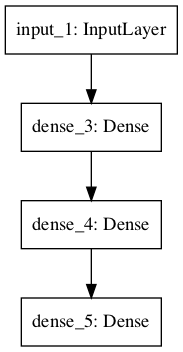

In [13]:
keras.utils.plot_model(model)

We can also show the input and output shapes for each layer in the graph

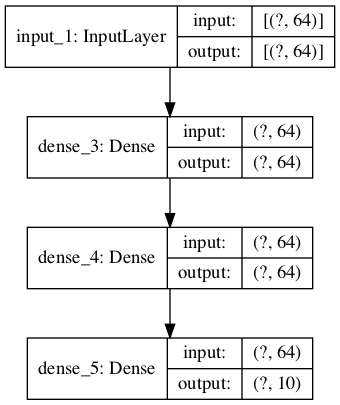

In [14]:
keras.utils.plot_model(model, show_shapes=True)

Once we have our model, we can use it like any other **Keras** model that we have seen, i.e. being able to train, evaluate and save the model simply.

In [15]:
# Specify the training configuration.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Trains for 5 epochs
history = model.fit(X_train, y_train, batch_size=32, epochs=5)

Train on 1437 samples
Epoch 1/5
1437/1437 [==============================] - 0s 159us/sample - loss: 1.0259 - accuracy: 0.7404
Epoch 2/5
1437/1437 [==============================] - 0s 36us/sample - loss: 0.2927 - accuracy: 0.9068
Epoch 3/5
1437/1437 [==============================] - 0s 34us/sample - loss: 0.1303 - accuracy: 0.9576
Epoch 4/5
1437/1437 [==============================] - 0s 31us/sample - loss: 0.1156 - accuracy: 0.9617
Epoch 5/5
1437/1437 [==============================] - 0s 30us/sample - loss: 0.1194 - accuracy: 0.9589


In [16]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss: {:.4}'.format(test_scores[0]))
print('Test accuracy: {:.3%}'.format(test_scores[1]))

360/360 - 0s - loss: 0.1793 - accuracy: 0.9694
Test loss: 0.1793
Test accuracy: 96.944%


### Defining multiple models from the same graph of layers

Since the `tf.keras.Model` is really just a convenience object that encapsulates a connected set of layers, we can form multiple models, or connected sets of layers (sub-graphs) from one defined graph of layers (or computation graph).

To illustrate, let us create an *auto-encoder*, that takes an input mapping it to a low dimensional representation by a neural network and then maps the same low dimensional representation back to the output, i.e. to learn an efficient low-dimensional representation (efficient data encoding) of our sample in an unsupervised manner.

Here we can create one large model to encapsulate the entire graph, called the *auto-encoder*, however we may wish to create sub models such as the *encoder* model to map the input sample to the low-dimensional representation and the *decoder* model to map the low-dimensional representation back to the input sample dimensions.

Lets illustrate with an example

Auto-encoder


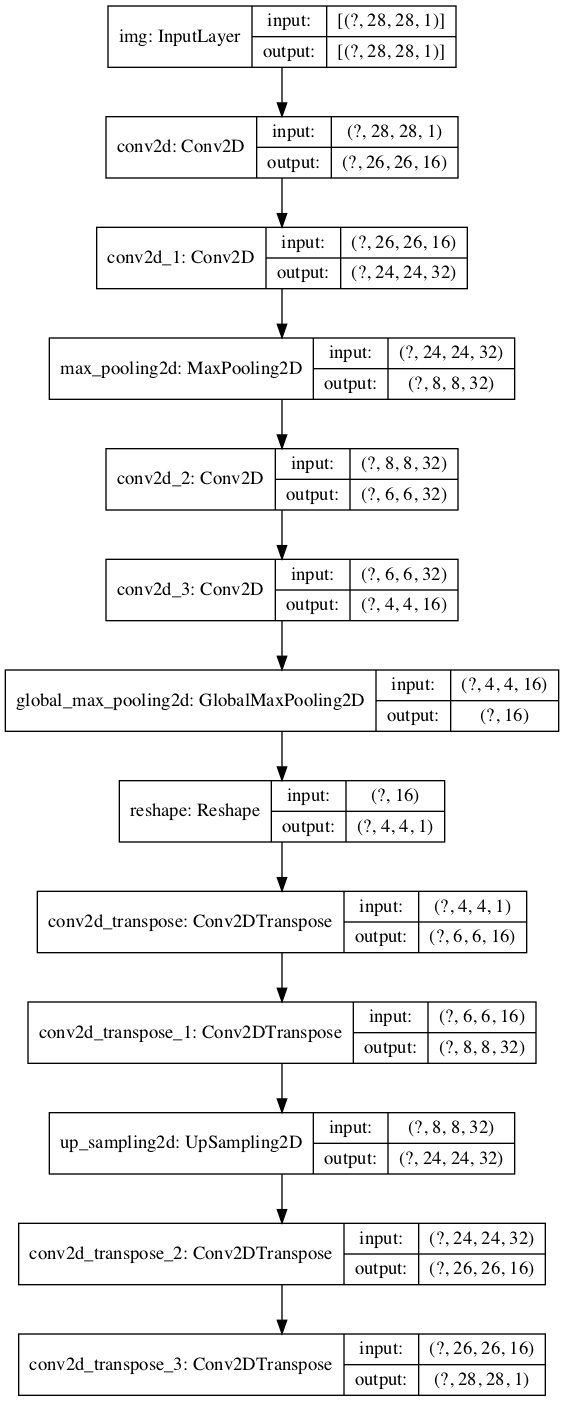

In [17]:
# Create one auto-encoder graph
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = keras.layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = keras.layers.Conv2D(32, 3, activation='relu')(x)
x = keras.layers.MaxPooling2D(3)(x)
x = keras.layers.Conv2D(32, 3, activation='relu')(x)
x = keras.layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Reshape((4, 4, 1))(encoder_output)
x = keras.layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = keras.layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = keras.layers.UpSampling2D(3)(x)
x = keras.layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = keras.layers.Conv2DTranspose(1, 3, activation='relu')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
encoder = keras.Model(encoder_input, encoder_output, name='encoder')
print('Auto-encoder')
keras.utils.plot_model(autoencoder, show_shapes=True)

Encoder


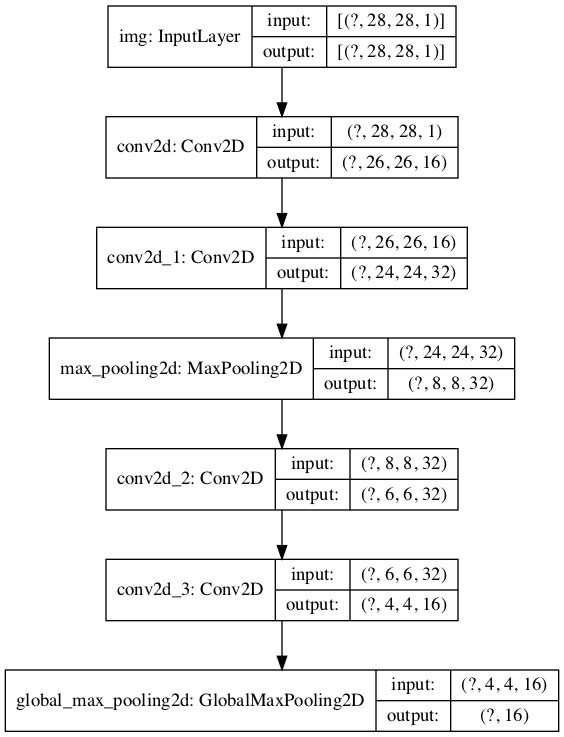

In [18]:
print('Encoder')
keras.utils.plot_model(encoder, show_shapes=True)

Due to the *auto-encoder* nature the architecture is symmetrical, since the reverse of a `Conv2D` layer is a `Conv2DTranspose` layer, and the reverse of a `MaxPooling2D` layer is an `UpSampling2D` layer.

We can also compose multiple models, as we can assume a model behaves like a layer, i.e. we can create the same *auto-encoder* architecture by composing the encoder and decoder model together, i.e.

In [19]:
# Create encoder graph
x = keras.layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = keras.layers.Conv2D(32, 3, activation='relu')(x)
x = keras.layers.MaxPooling2D(3)(x)
x = keras.layers.Conv2D(32, 3, activation='relu')(x)
x = keras.layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = keras.layers.GlobalMaxPooling2D()(x)

# Create decoder graph
decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = keras.layers.Reshape((4, 4, 1))(decoder_input)
x = keras.layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = keras.layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = keras.layers.UpSampling2D(3)(x)
x = keras.layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = keras.layers.Conv2DTranspose(1, 3, activation='relu')(x)

# Create models for each graph
encoder = keras.Model(encoder_input, encoder_output, name='encoder')
decoder = keras.Model(decoder_input, decoder_output, name='decoder')

# Connect the two models together
autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)

# Create the auto-encoder model that composes the two encoder and decoder models
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                18672     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9569      
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
_________________________________________________________________


A common case that we can use model nesting is to create an *ensemble* of models. Such as the example below combining multiple models and averaging their predictions.

In [20]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = keras.layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)

model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = keras.layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

## Multi-Output & Multi-Input models

We may want to create a model that that takes multiple inputs and or outputs multiple outputs.

For example we may want to model to rank customer emails for a business, by priority and routing them to the correct group mailing list email for resolving. 

This model could have three inputs:
* email subject as text input
* email body as text input
* any optional tags based existing categorical tags (that the company has about this email address already)

And two outputs:
* priority score between 0 and 1 (scalar sigmoid output)
* the group mailing list email that should resolve the inbound email (a softmax output over the set of departments)



In [21]:
amount_tags = 12  # Number of unique tags
amount_words = 10000  # Size of vocabulary obtained when preprocessing text data
amount_mailing_lists = 4  # Number of mailing lists for predictions

# Variable-length sequence of ints
subject_input = keras.Input(shape=(None,), name='subject')
# Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name='body')
# Binary vectors of size `amount_tags`
tags_input = keras.Input(shape=(amount_tags,), name='tags')

# Embed each word in the subject into a 64-dimensional vector
subject_features = keras.layers.Embedding(amount_words, 64)(subject_input)
# Embed each word in the text into a 64-dimensional vector
body_features = keras.layers.Embedding(amount_words, 64)(body_input)

# Reduce sequence of embedded words in the subject into a single 128-dimensional vector
subject_features = keras.layers.LSTM(128)(subject_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = keras.layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = keras.layers.concatenate([subject_features, body_features, tags_input])

# Apply a sigmoid (logistic regression) for priority prediction on top of the features
priority_pred = keras.layers.Dense(1, name='priority')(x)
# Apply a mailing_list classifier on top of the features
mailing_list_pred = keras.layers.Dense(
    amount_mailing_lists, name='mailing_list')(x)

# Instantiate an end-to-end model predicting both priority and mailing_list
model = keras.Model(inputs=[subject_input, body_input, tags_input],
                    outputs=[priority_pred, mailing_list_pred])

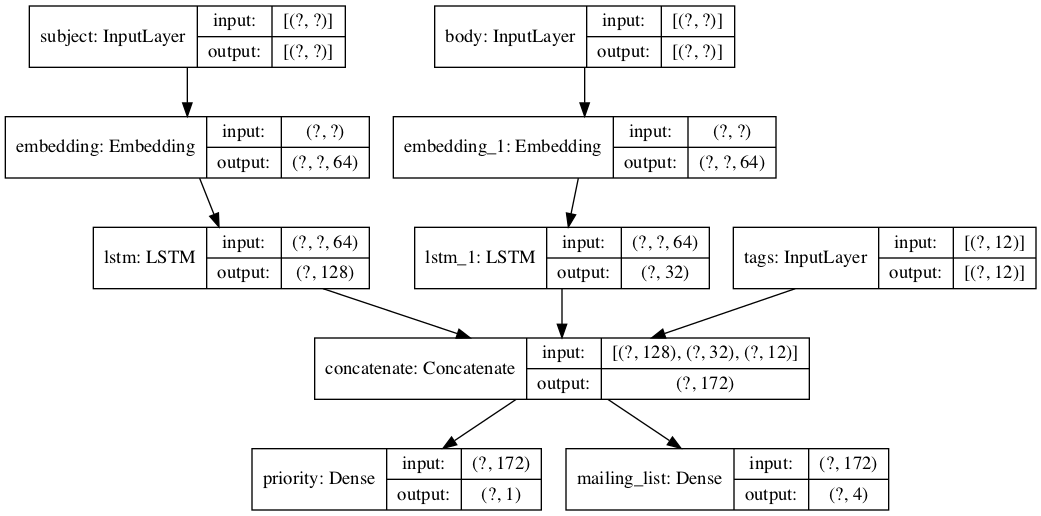

In [22]:
keras.utils.plot_model(model, show_shapes=True)

We can assign different losses to each output, and thus can assign different weights to each loss - to control their contribution to the total training loss when we compile the model.

In [23]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss=[keras.losses.BinaryCrossentropy(from_logits=True),
                    keras.losses.CategoricalCrossentropy(from_logits=True)],
              loss_weights=[1., 0.2])

We can also specify the losses based on their names as well

In [24]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={'priority':keras.losses.BinaryCrossentropy(from_logits=True),
                    'mailing_list': keras.losses.CategoricalCrossentropy(from_logits=True)},
              loss_weights=[1., 0.2])

We can train the model, where we pass the data ( or yield it from the dataset object) as either as a:


* tuple of lists, e.g. `([X_subject, X_body, X_tags], [y_priority, y_mailing_list])`
* tuple of dictionaries, e.g. `({'subject': X_subject, 'body': X_body, 'tags': X_tags}, {'priority': y_priority, 'mailing_list': y_mailing_list})`

In [25]:
# Some random input data (X)
X_subject = np.random.randint(amount_words, size=(1280, 10))
X_body = np.random.randint(amount_words, size=(1280, 100))
X_tags = np.random.randint(2, size=(1280, amount_tags)).astype('float32')

# Some random targets (y)
y_priority = np.random.random(size=(1280, 1))
y_mailing_list = np.random.randint(2, size=(1280, amount_mailing_lists))

model.fit({'subject': X_subject, 'body': X_body, 'tags': X_tags},
          {'priority': y_priority, 'mailing_list': y_mailing_list},
          epochs=2,
          batch_size=32)

Train on 1280 samples
Epoch 1/2
1280/1280 [==============================] - 3s 2ms/sample - loss: 1.2666 - priority_loss: 0.6979 - mailing_list_loss: 2.8436
Epoch 2/2
1280/1280 [==============================] - 1s 994us/sample - loss: 1.2671 - priority_loss: 0.6963 - mailing_list_loss: 2.8540


## Non-linear networks

We can also create non-linear graphs, where the models with the layers are not connected sequentially. 

An example of type of model that is non-linear is a *Residual Neural Network* (ResNet), which is a neural network that has *skip connections* or *shortcuts* to jump over some layers. Often implemented in double or triple layer skips that contain nonlinearities (ReLU) and batch normalization in between.

We can connect multiple connections into the same node by using the `keras.layers.add()` layer where we pass a list of of input tensors to add together. There also exists other layers to combine multiple layers such as the `subtract`, `average`, `concatenate`, `dot`, `maximum`, `minimum` and `multiply` layers in `keras.layers` module. A full list can be seen [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers).

To illustrate lets create an example of a ResNet model:

Model: "example_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_9[0][0]                   
_____________________________________________________________________________________

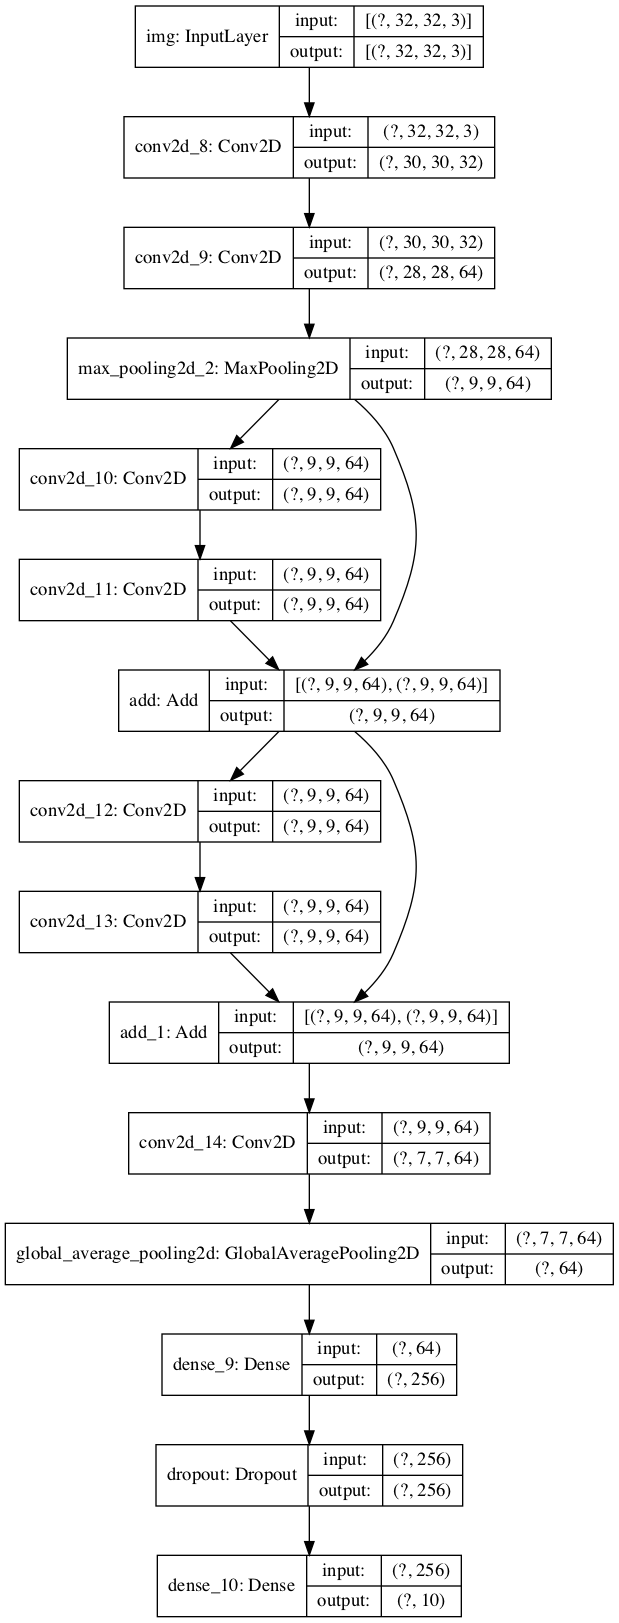

In [26]:
inputs = keras.Input(shape=(32, 32, 3), name='img')
x = keras.layers.Conv2D(32, 3, activation='relu')(inputs)
x = keras.layers.Conv2D(64, 3, activation='relu')(x)
block_1_output = keras.layers.MaxPooling2D(3)(x)

x = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
x = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
block_2_output = keras.layers.add([x, block_1_output])

x = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
x = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
block_3_output = keras.layers.add([x, block_2_output])

x = keras.layers.Conv2D(64, 3, activation='relu')(block_3_output)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name='example_resnet')
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Share layers

We can also easily share the same layer in our model, i.e. a single layer instance is reused multiple times in the same model so that it learns a mapping that corresponds to multiple paths in the graph of layers.

Common use cases for sharing a layer would be to create a shared embedding (encoding inputs) if the inputs come from similar spaces.

For example

In [27]:
# Embedding for 10000 unique words mapped to 128-dimensional vectors
shared_embedding = keras.layers.Embedding(10000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype='int32')

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype='int32')

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

### Extract and reuse nodes

The graph of layers is a static data structure, thus it can be directly accessed and inspected. This means that you can access the outputs from each node in the graph and reuse them elsewhere, which is useful for feature extraction and taking parts of a pre-trained model. 

For an example lets create a model that outputs all the output nodes for a given pre-trained graph, e.g. the VGG19 model with its weights trained on ImageNet:

In [28]:
vgg19 = tf.keras.applications.VGG19()

In [29]:
# query the graph data structure
features_list = [layer.output for layer in vgg19.layers]

# Create a new model that that outputs all the nodes values from the intermediate layers
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype('float32')
extracted_features = feat_extraction_model(img)

## Custom layers

Although `tf.keras` includes many useful built-in layers, a few of [these](https://www.tensorflow.org/api_docs/python/tf/keras/layers) being:
* Convolutional layers: `Conv1D`, `Conv2D`, `Conv3D`, `Conv2DTranspose`
* Pooling layers: `MaxPooling1D`, `MaxPooling2D`, `MaxPooling3D`, `AveragePooling1D`
* RNN layers: `GRU`, `LSTM`, `ConvLSTM2D`
* `BatchNormalization`, `Dropout`, `Embedding`, etc.

We can simply create our own custom layer by subclassing `tf.keras.layers.Layer` and implementing the following methods:
* `__init__`: Save configuration in member variables
* `build()`: Create the weights of the layer. Add weights with the `add_weight()` method. Will be called once from `__call__`, when the shapes of the input and `dtype` is known.
* `call()`: Define the forward pass. I.e. applying the actual logic of applying the layer to the input tensors (which should be passed as the first argument)
* Optionally, a layer can be serialized by implementing the `get_config()` method and the `from_config()` class method.

Conviently the [layer class](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer), `tf.keras.layers.Layer` manages the weights, losses, updates and inter-layer connectivity for us.

Here's an example of a custom layer that implements a basic dense layer:

In [30]:
class CustomDense(keras.layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    def get_config(self):
        return {'units': self.units}


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

In [31]:
# Example of serializing and deserializing the layer
config = model.get_config()

# deserializing the layer
new_model = keras.Model.from_config(
    config, custom_objects={'CustomDense': CustomDense})

# Custom models

Another way to create our own models, slightly less flexible of constructing our custom models is to subclass the `tf.keras.Model` and define our own forward pass. Here we create layers in the `__init__()` method and use them as attributes of the class instance. We can define the forward pass in the `call()` method. However this is not the preferred way to create custom models *Keras*, the functional API described above is.

An example would be:

In [32]:
class MyModel(tf.keras.Model):

    def __init__(self, num_classes=10):
        super(MyModel, self).__init__(name='my_custom_model')
        self.num_classes = num_classes
        # Define your layers here.
        self.dense_1 = keras.layers.Dense(32, activation='relu')
        self.dense_2 = keras.layers.Dense(num_classes)

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.dense_1(inputs)
        return self.dense_2(x)
    
    
model = MyModel(num_classes=10)

# Keras Callbacks

Here a `tf.keras.callbacks.Callback` object can be passed to a model to customize its behaviour during training, predicting or testing. It is mainly used to customize training behaviour. We can write our own custom callbacks to process the current models state at a [particular step](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) within each iteration of training or using the model for instance at `on_batch_end`, `on_epoch_end` or `on_test_end` etc.

Common built-in callbacks in `tf.keras.callbacks` include:

* `tf.keras.callbacks.ModelCheckpoint`: Saves checkpoints of the model at regular intervals
* `tf.keras.callbacks.LearningRateScheduler`: Dynamically changes the learning rate
* `tf.keras.callbacks.EarlyStopping`: Interrupts training when validation performance has stopped improving
* `tf.keras.callbacks.TensorBoard`: Output a log for use in monitoring the model's behaviour using TensorBoard

We can use a `tf.keras.callbacks.Callback`, here for training by passing it to the models fit method:

In [33]:
callbacks = [
    # Interrupt training if `val_loss` (Validation loss) stops improving for over 2 epochs
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    # Write TensorBoard logs to `./tmp_logs` directory
    tf.keras.callbacks.TensorBoard(log_dir='./tmp_logs')
]

# Create a simple model to use it in
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=64),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, validation_split=0.2, callbacks=callbacks)

Train on 1149 samples, validate on 288 samples
Epoch 1/10
1149/1149 [==============================] - 0s 244us/sample - loss: 2.8799 - accuracy: 0.3507 - val_loss: 0.9007 - val_accuracy: 0.7153
Epoch 2/10
1149/1149 [==============================] - 0s 46us/sample - loss: 0.5713 - accuracy: 0.8190 - val_loss: 0.4420 - val_accuracy: 0.8681
Epoch 3/10
1149/1149 [==============================] - 0s 44us/sample - loss: 0.3110 - accuracy: 0.9147 - val_loss: 0.3578 - val_accuracy: 0.8993
Epoch 4/10
1149/1149 [==============================] - 0s 48us/sample - loss: 0.2139 - accuracy: 0.9408 - val_loss: 0.3427 - val_accuracy: 0.8924
Epoch 5/10
1149/1149 [==============================] - 0s 46us/sample - loss: 0.1606 - accuracy: 0.9591 - val_loss: 0.2985 - val_accuracy: 0.9062
Epoch 6/10
1149/1149 [==============================] - 0s 45us/sample - loss: 0.1227 - accuracy: 0.9669 - val_loss: 0.2565 - val_accuracy: 0.9306
Epoch 7/10
1149/1149 [==============================] - 0s 46us/sample

We can also write our own custom callbacks like the following:

In [34]:
class LossHistory(keras.callbacks.Callback):

    def on_train_begin(self, logs):
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.losses.append(logs.get('loss'))

[[1](https://www.tensorflow.org/guide/keras/functional)]